In [6]:
import wandb

# Initialize a new run
wandb.init()

In [8]:
# get all projects
projects = wandb.Api().projects()
# print the project names
for project in projects:
    print(project.name)
    # get all runs in the project
    if hasattr(project, 'runs'):
        runs = project.runs()
        # print the run names
        for run in runs:
            print(run.name)
            # get all files in the run
            files = run.files()
            # print the file names
            for file in files:
                print(file.name)
                # download the file
                file.download(replace=True)

qwen-fp8
Math-reasoning-mixed-fp32
Math-reasoning-mixed-fp16
Math-reasoning-mixed-fp8
Qwen2.5-7B-Instruct-function-calling-mixed-fp16
Qwen2.5-7B-Instruct-function-calling-mixed-fp8


In [33]:
# visualize the downloaded files
# wandb.finish()
import os
import matplotlib.pyplot as plt


In [34]:
api = wandb.Api()

# Access a specific run
run_fp16 = api.run("vinhpx/Math-reasoning-mixed-fp16/ivggoj7a")
run_fp8 = api.run("vinhpx/Math-reasoning-mixed-fp8/runs/s82vj3o6")
# run = project.runs("ivggoj7a")


In [35]:
# Get the metrics history
metrics_df_fp16 = run_fp16.history()
metrics_df_fp8 = run_fp8.history()

# Get config values
config = run.config

# Get summary metrics (final values)
summary = run.summary

In [36]:
metrics_df_fp8


,eval/loss,eval/perplexity,_step,epoch,train/loss,_timestamp,_runtime,train/step,train/learning_rate
0,NaN,NaN,20,NaN,0.804702,1.743827e+09,30.147430,20.0,4.997024e-05
1,NaN,NaN,40,NaN,0.777983,1.743827e+09,38.357112,40.0,4.994048e-05
2,NaN,NaN,60,NaN,0.756140,1.743827e+09,46.564801,60.0,4.991072e-05
3,NaN,NaN,150,NaN,0.702737,1.743827e+09,83.481926,150.0,4.977681e-05
4,NaN,NaN,170,NaN,0.708327,1.743827e+09,91.693899,170.0,4.974705e-05
...,...,...,...,...,...,...,...,...,...
495,NaN,NaN,33450,NaN,0.524012,1.743841e+09,13776.870376,33450.0,2.276582e-07
496,NaN,NaN,33490,NaN,0.523944,1.743841e+09,13793.292981,33490.0,1.681397e-07
497,NaN,NaN,33520,NaN,0.523885,1.743841e+09,13805.602377,33520.0,1.235009e-07
498,NaN,NaN,33540,NaN,0.523835,1.743841e+09,13813.806775,33540.0,9.374163e-08


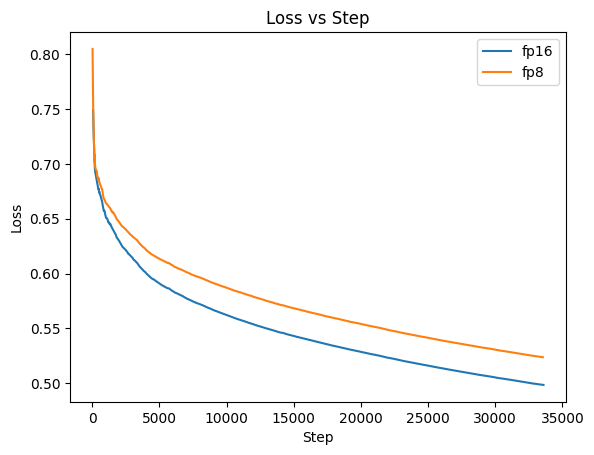

In [37]:
# visualize the metrics step and train/loss
plt.plot(metrics_df_fp16["train/step"], metrics_df_fp16["train/loss"], label="fp16")
plt.plot(metrics_df_fp8["train/step"], metrics_df_fp8["train/loss"], label="fp8")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Loss vs Step")
plt.legend()
plt.show()

In [38]:
from datasets import load_dataset

data = load_dataset("vinhpx/math_natural_reasoning", split="train")

In [39]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-1.5B-Instruct")

In [47]:
def tokenize_function(batch):
    # question = data["question"]
    # response = data["response"]
    lengths = []
    for question, response in zip(batch["question"], batch["response"]):
        
        messages = [
            {
                "role": "user",
                "content": question
            },
            {
                "role": "assistant",
                "content": response
            }
        ]
        # Tokenize and prepare input
        encodings = tokenizer.apply_chat_template(
            messages,
            tokenize=True
        )
        lengths.append(encodings)
    # Add the lengths to the batch
    batch["lengths"] = lengths
    return batch

data = data.filter(lambda x: x['question'] != "" and x['response'] != "")
            # filter all question or response is null
data = data.filter(lambda x: x['question'] is not None and x['response'] is not None)
            
# Tokenize the dataset
tokenized_data = data.map(tokenize_function, batched=True, num_proc=10)

Map (num_proc=10): 100%|██████████| 2263750/2263750 [06:53<00:00, 5471.67 examples/s] 


In [50]:
# count if lengths > 1024
len(tokenized_data.filter(lambda x: len(x["lengths"]) > 1024))


Filter: 100%|██████████| 2263750/2263750 [04:47<00:00, 7881.16 examples/s] 


374993

In [52]:
large_data = tokenized_data.filter(lambda x: len(x["lengths"]) > 1024, num_proc=12)

Filter (num_proc=12): 100%|██████████| 2263750/2263750 [00:41<00:00, 54252.20 examples/s]
